{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Dec 10 13:54:54 2024', '__version__': '1.0', '__globals__': [], 'Hext': array([[47.597 ],
       [49.001 ],
       [48.9875],
       ...,
       [63.9455],
       [63.9455],
       [63.9455]]), 'Qhotdata': array([[1.38502e+03],
       [1.37607e+03],
       [1.45886e+03],
       ...,
       [5.20000e-01],
       [5.20000e-01],
       [5.20000e-01]]), 'Qudata': array([[ 892.00252965],
       [ 883.96205898],
       [ 884.85563964],
       ...,
       [1300.9145346 ],
       [1301.50879005],
       [1302.09821238]]), 'Text': array([[20.47],
       [20.43],
       [20.39],
       ...,
       [15.84],
       [15.84],
       [15.84]]), 'Tman_GF': array([[ 9.32],
       [ 9.32],
       [ 9.32],
       ...,
       [14.3 ],
       [14.3 ],
       [14.09]]), 'Toutass': array([[ 7.5],
       [ 7.5],
       [ 7.6],
       ...,
       [13.7],
       [13.8],
       [14. ]]), 'Toutrefr1': array([[ 9.90991],
       [ 9.90991],
  

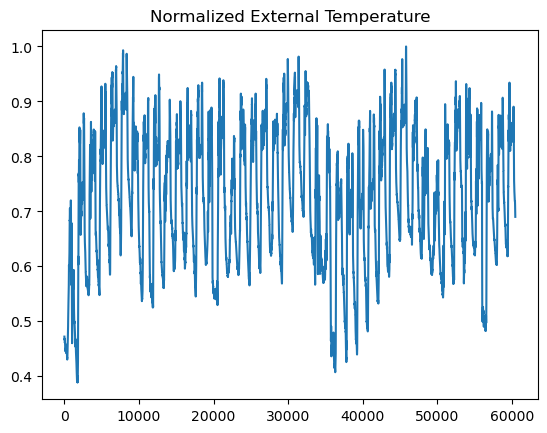

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load raw data
data = scipy.io.loadmat('raw_data.mat')

print(data)
# Extract variables
Trit_GF = data['Trit_GF'].flatten()
Qhotd = data['Qhotdata'].flatten()
statusAsst = data['statusAsstdata'].flatten()
weektime = data['weektime'].flatten()
wendtime = data['wendtime'].flatten()
time = data['time'].flatten()
Text = data['Text'].flatten()
Hext = data['Hext'].flatten()
Tman_GF = data['Tman_GF'].flatten()
Toutass = data['Toutass'].flatten()
buildtot = data['buildtot'].flatten()
Qu = data['Qudata']

# Example of adjustments in Python
# Combine week and weekend times
WEEK = weektime + wendtime / 2

# Combine status variables
Status_global = data['stato1'] + data['stato2'] + data['stato3'] + data['stato4']

# Normalize data function
def normalize(data):
    return data / np.mean(data)

# Normalize selected variables
Text_normalized = normalize(Text)
Hext_normalized = normalize(Hext)

# Adjust training data
one_week = 231840 - 221760
nb_weeks = 3  # Change as required
start = 4 * one_week
end_train = 10 * one_week

training_data = {
    "Text_train": Text_normalized[start:end_train],
    "Hext_train": Hext_normalized[start:end_train],
    "Status_global": Status_global[start:end_train],
    "Trit_GF_train": Trit_GF[start:end_train],
    "Tman_GF_train": Tman_GF[start:end_train]
}

# Plotting
plt.figure()
plt.plot(training_data["Text_train"])
plt.title('Normalized External Temperature')
plt.show()


In [13]:
len(Text_normalized)

240001